In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import batman
import corner
import lightkurve as lk

In [2]:
# --- 0. Set your target ID ---
target_id = 'TIC 399860444'

In [3]:
# --- 1. Download and normalize the light curve data ---
# This line performs the search, downloads the first result, and normalizes it.
data = lk.search_lightcurve(target_id)[0].download().normalize()

In [4]:
# Extract raw time, flux, and flux error values
time_real = data.time.value
flux_real = data.flux.unmasked.value
flux_err_real = data.flux_err.unmasked.value

In [5]:
# --- 2. Clean the data: Remove NaN values ---
# This is how 'time_clean' (and corresponding flux/flux_err) are obtained.
mask = np.isfinite(time_real) & np.isfinite(flux_real) & np.isfinite(flux_err_real)
time_clean = time_real[mask]
flux_clean = flux_real[mask]
flux_err_clean = flux_err_real[mask]

In [6]:
# Now, time_clean, flux_clean, and flux_err_clean are your 'd_clean' arrays.

# --- 3. Calculate Periodograms to get initial period and epoch ---
# Lomb-Scargle Periodogram (for general periodicity)
pd_ls = data.to_periodogram()
print(f"Lomb-Scargle Period at Max Power: {pd_ls.period_at_max_power}")

Lomb-Scargle Period at Max Power: 0.6185846359947117 d


In [7]:
# Box-Least Squares (BLS) Periodogram (for transit signals)
pd_bls = data.to_periodogram(method='bls')
period_bls = pd_bls.period_at_max_power
epoch_bls = pd_bls.transit_time_at_max_power
print(f"BLS Period at Max Power: {period_bls}")
print(f"BLS Epoch at Max Power: {epoch_bls}")


BLS Period at Max Power: 2.468522165591752 d
BLS Epoch at Max Power: 2012.5190001043813


In [8]:
# --- 4. Define initial parameters for the transit model ---
# These initial guesses are crucial for the MCMC to start effectively.
# We use values from the BLS periodogram and typical values for other parameters.
initial_rp = 0.05 # Initial guess for planet radius ratio (e.g., a small planet)
initial_a = 10.0  # Initial guess for semi-major axis (typical for TESS planets)
initial_inc = 88.0 # Initial guess for inclination (near 90 for transiting)
initial_t0 = epoch_bls.value # Use BLS epoch
initial_period = period_bls.value # Use BLS period
initial_u1 = 0.4  # Initial guess for limb darkening u1
initial_u2 = 0.2  # Initial guess for limb darkening u2

# Combine into a single initial guess array
initial = [initial_rp, initial_a, initial_inc, initial_t0, initial_period, initial_u1, initial_u2]

In [9]:
# --- 5. Define the transit model function using batman ---
def transit_model(theta, time):
    rp, a, inc, t0, per, u1, u2 = theta
    params = batman.TransitParams()
    params.t0 = t0
    params.per = per
    params.rp = rp
    params.a = a
    params.inc = inc
    params.ecc = 0.0
    params.w = 90.0 # Longitude of periastron, commonly 90 for circular orbits
    params.u = [u1, u2]
    params.limb_dark = "quadratic"
    
    m = batman.TransitModel(params, time)
    return m.light_curve(params)

In [10]:
# --- 6. Define log prior ---
# This sets the boundaries and initial probability for each parameter.
def log_prior(theta):
    rp, a, inc, t0, per, u1, u2 = theta
    
    # Priors for physical parameters
    if not (0.001 < rp < 0.5): # rp must be positive and less than 0.5 stellar radii
        return -np.inf
    if not (1.0 < a < 50.0): # a must be greater than 1 stellar radius (planet outside star)
        return -np.inf
    if not (80.0 < inc < 90.0): # inclination for transiting planets
        return -np.inf
    
    # t0 should be within the observed time range to avoid fitting non-existent transits
    if not (np.min(time_clean) - per/2 < t0 < np.max(time_clean) + per/2):
        return -np.inf
    
    # Period should be positive and within a reasonable range for this dataset
    if not (0.1 < per < 20.0): # Example range, adjust based on your system
        return -np.inf
    
    # Limb darkening coefficients should be between 0 and 1
    if not (0 <= u1 <= 1 and 0 <= u2 <= 1):
        return -np.inf
    
    return 0.0 # Return 0 for flat prior within bounds (log(1) = 0)

In [11]:
# --- 7. Define log likelihood ---
# This measures how well the model fits the data.
def log_likelihood(theta, time, flux, flux_err):
    model_flux = transit_model(theta, time)
    inv_sigma2 = 1.0 / (flux_err ** 2)
    # The term np.log(2 * np.pi * flux_err ** 2) is often included for completeness
    return -0.5 * np.sum((flux - model_flux) ** 2 * inv_sigma2 + np.log(2 * np.pi * flux_err ** 2))

In [12]:
# --- 8. Define log posterior (log probability) ---
# This is the combination of prior and likelihood.
def log_probability(theta, time, flux, flux_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf # If prior is -inf, posterior is -inf
    return lp + log_likelihood(theta, time, flux, flux_err)

In [13]:
# --- 9. Setup and Run MCMC sampler with emcee ---
# Use cleaned data arrays for MCMC
data_for_mcmc = (time_clean, flux_clean, flux_err_clean)

ndim = len(initial) # Number of parameters in our model
nwalkers = 32 # Number of MCMC walkers (should be >= 2*ndim)
# Initial positions for the walkers: spread them slightly around the initial guess
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=data_for_mcmc)

print("Starting MCMC run...")
# Run the MCMC sampler
# The second argument (5000) is the number of steps each walker takes
sampler.run_mcmc(pos, 5000, progress=True)
print("MCMC run complete.")

Starting MCMC run...


100%|███████████████████████████████████████| 5000/5000 [01:31<00:00, 54.70it/s]

MCMC run complete.


In [14]:
# --- 10. Extract and process samples ---
# Discard the 'burn-in' phase (first 1000 steps) and thin the chain to reduce autocorrelation.
# Thinning by 15 means we keep 1 sample out of every 15.
samples = sampler.get_chain(discard=1000, thin=15, flat=True)

print(f"Number of samples after burn-in and thinning: {samples.shape[0]}")

Number of samples after burn-in and thinning: 8512


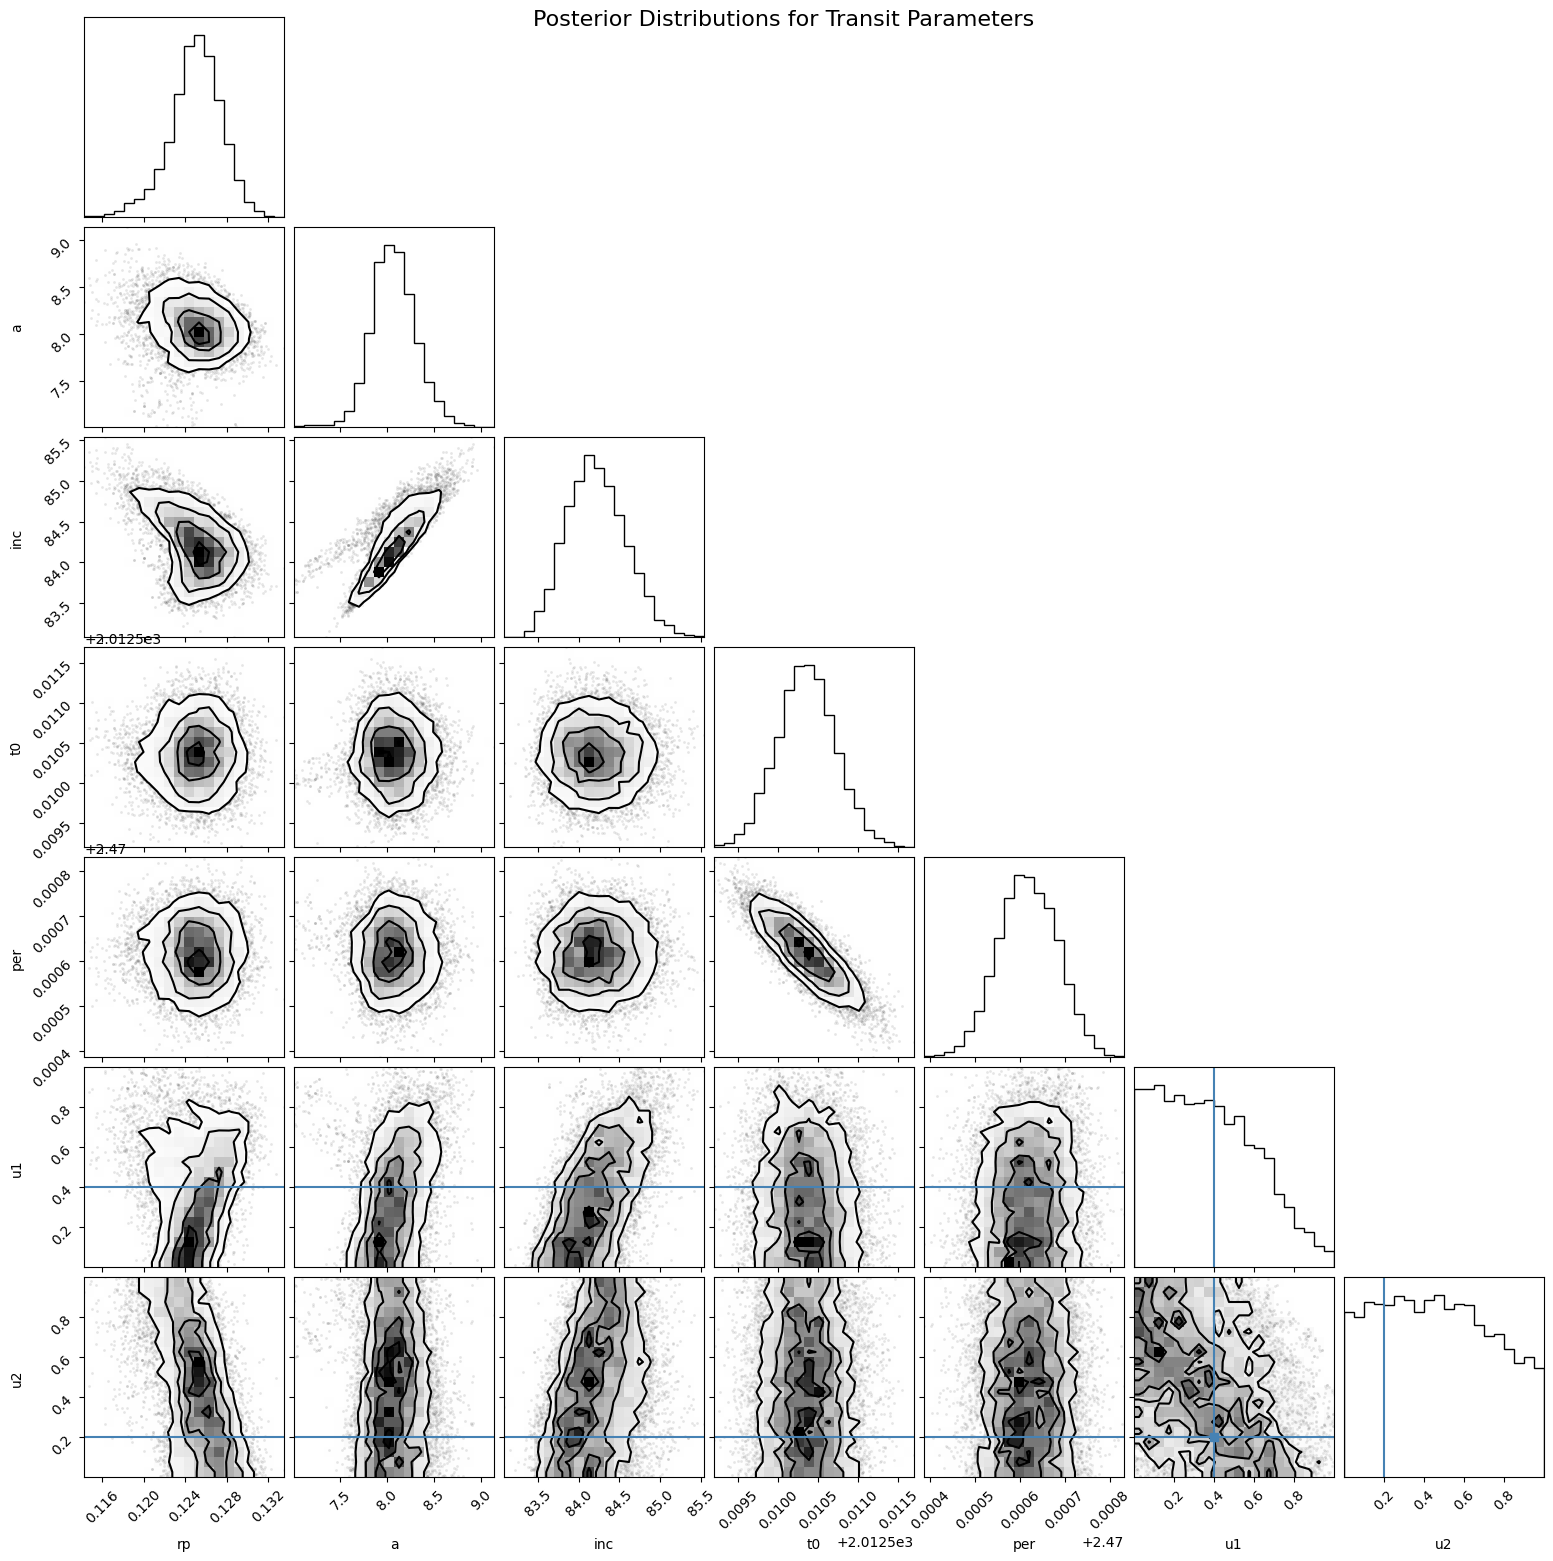

In [15]:
# --- 11. Plot corner plot for posterior distributions ---
# This helps visualize the posterior distributions and correlations between parameters.
fig = corner.corner(samples, labels=["rp", "a", "inc", "t0", "per", "u1", "u2"], truths=initial)
plt.suptitle("Posterior Distributions for Transit Parameters", fontsize=16)
plt.show()

In [16]:
# --- 12. Calculate best-fit parameters (median of posteriors) ---
best_fit_params = np.median(samples, axis=0)

# Print best-fit parameters with uncertainties (from 16th and 84th percentiles)
labels = ["rp", "a", "inc", "t0", "per", "u1", "u2"]
for i, label in enumerate(labels):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{+{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], label)
    print(txt)

\mathrm{rp} = 0.1251_{-0.0024}^{+0.0022}
\mathrm{a} = 8.0625_{-0.2140}^{+0.2398}
\mathrm{inc} = 84.1975_{-0.3424}^{+0.3844}
\mathrm{t0} = 2012.5104_{-0.0004}^{+0.0004}
\mathrm{per} = 2.4706_{-0.0001}^{+0.0001}
\mathrm{u1} = 0.3515_{-0.2429}^{+0.2832}
\mathrm{u2} = 0.4582_{-0.3075}^{+0.3273}
